In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import pyvistaqt as pvqt
from ripser import Rips, lower_star_img
import os

In [18]:
# Note: This should be <YOUR_LOCATION>/3DBioImaging
os.getcwd()

dat = np.load("data/Data_042721/AC_cell_published_testset/single_blocked_cell_img.npy")

#dat = np.load("abs_mask.npy")

# Use this to get rid of last x1 dimension:
dat = np.squeeze(dat)

np.shape(dat)

(125, 256, 256)

In [3]:
"""
pc = []
scale = 2
for n in range(len(img_array)):
    tmp = np.where(img_array[n] > 0)
    for i in range(len(tmp[0])):
        pc.append([tmp[0][i],tmp[1][i], n/scale])
pc = np.array(pc)
"""

'\npc = []\nscale = 2\nfor n in range(len(img_array)):\n    tmp = np.where(img_array[n] > 0)\n    for i in range(len(tmp[0])):\n        pc.append([tmp[0][i],tmp[1][i], n/scale])\npc = np.array(pc)\n'

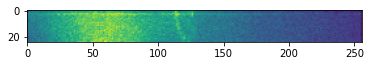

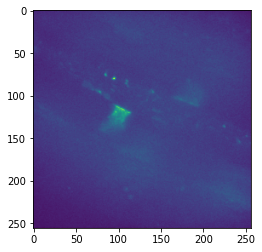

In [19]:
# Plot one slice:
plt.imshow(dat[0:24,120,:])
plt.show()

plt.imshow(dat[25,:,:])
plt.show()

In [52]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


rips = Rips(maxdim=2)
#data = np.load("")
data = dat
"""
data = plt.imread("18.png")
data = rgb2gray(data)
data = data - np.min(data)
data = 1 - np.abs(data)
data = data[:,0:600]
data += 0.01 * np.random.randn(*data.shape)
#data[300,314] = 10
#data[140,375] = 10
"""

# Mock some data:
ts = np.linspace(-1, 1, 100)
x1 = np.exp(-ts**2/(0.1**2))
ts -= 0.4
x2 = np.exp(-ts**2/(0.1**2))
data = -x1[None, :]*x1[:, None] - 2*x1[None, :]*x2[:, None] - 3*x2[None, :]*x2[:, None]
data = data - np.min(data)
data = data / np.max(np.abs(data))
#data[69,69] = 10
#data = np.abs(data) * 255

#plt.imshow(data)
#plt.colorbar()

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


array([[0.3376722 , 0.9699592 ],
       [0.67099154, 0.98288852],
       [0.        ,        inf]])

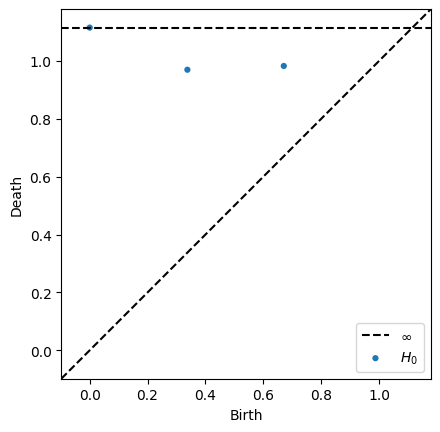

In [55]:
diagrams = lower_star_img(data)
#diagrams = rips.fit_transform(data, distance_matrix=True)
#diagrams = rips.fit_transform(data)
rips.plot(diagrams)
diagrams

In [57]:
# For now, set threshold equal to 1:
tau = 0.2

J = np.zeros(np.shape(data))

# Combine H0 and H1 holes into here:
#dgm = np.concatenate((diagrams[0], diagrams[1], diagrams[2]))
dgm = diagrams

# Array for lifetimes of H0 and H1 holes:
lifetimes = np.zeros(np.shape(dgm)[0])
births = np.zeros(np.shape(lifetimes))
deaths = np.zeros(np.shape(lifetimes))

for i in range(np.shape(dgm)[0]):
    births[i] = dgm[i,0]
    deaths[i] = dgm[i,1]
    
lifetimes = deaths - births

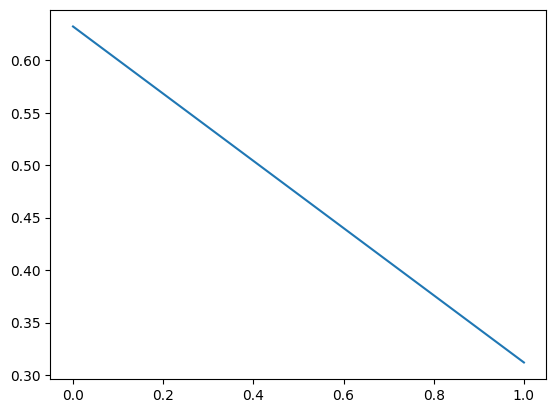

In [58]:
# Note that values of infinity are okay (infinite lifetimes means holes never die)
plt.plot(lifetimes)

In [59]:
# Select the indices below threshold value:
indices = np.argwhere((tau < lifetimes) & (lifetimes != np.Inf))
desc_order = np.argsort(np.squeeze(deaths[indices]))[::-1]
indices = indices[desc_order]
#print(dgm)
#dgm[indices, 0]
dgm[indices, :]

array([[[0.67099154, 0.98288852]],

       [[0.3376722 , 0.9699592 ]]])

In [60]:
X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
X = X.flatten()
Y = Y.flatten()

# Store the collection of birth-pixel coordinates
birth_coords = list()
death_coords = list()

# Binary output indicating boundary:
J = np.zeros(np.shape(data))

for idx in indices:
    # Birth pixel coordinate:
    bidx = np.argmin(np.abs(data + dgm[idx, 0]))
    birth_coord = np.array([X[bidx], Y[bidx]])
    birth_coords.append(birth_coord)

    # Death pixel coordinate:
    bidx = np.argmin(np.abs(data + dgm[idx, 1]))
    death_coord = np.array([X[bidx], Y[bidx]])
    death_coords.append(death_coord)
    
    # Get all pixels connected to the birth pixel right before its death:
    birth_val = data[birth_coord[0],birth_coord[1]]
    C = (birth_val <= data) & (data < dgm[idx, 1]) # dgm[idx, 1] is death value at current index from persistence diagram
    C_ = list()
    for i in range(np.shape(C)[0]):
        for j in range(np.shape(C)[1]):
            if(C[i,j]):
                C_.append(np.array([i,j]))

    # Check if C contains death pixels of previous components:
    intersection = list() #list(set(C_) & set(death_coords))
    # Find intersection of ds and C:
    for i1 in C_:
        for i2 in death_coords:
            if(np.array_equal(i1, i2)):
                intersection.append(i1)
                
    pts = (data[intersection].flatten()).tolist()
    pts.append(dgm[idx, 1][0])
    new_dval = min(pts)
    
    # Ensure C does not overlap with any previous component:
    #C = (birth_val <= data) & (data < new_dval)
    
    # Mark the component for this diagram point in the output:
    J[C] = 1

In [46]:
new_dval

0.0

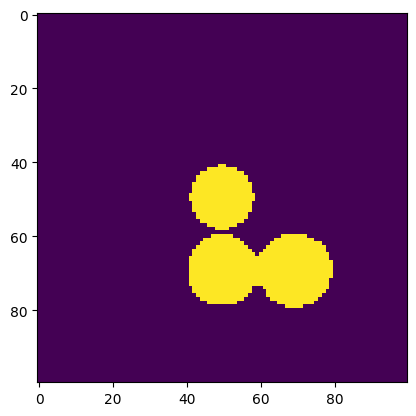

In [61]:
plt.imshow(J)

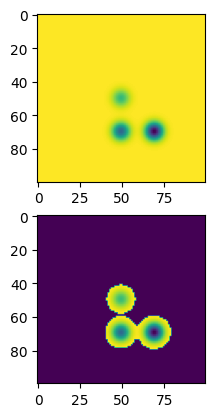

In [62]:
plt.subplot(211)
plt.imshow(data)
plt.subplot(212)
plt.imshow(data * J)